In [1]:

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torchvision
import numpy as np
from torch.utils.data import Subset
from moe import MOE_LeNET_ResNet
device=torch.device("cuda:7" if torch.cuda.is_available() else "cpu")


In [2]:
import argparse
import argparse
import sys

# 检查并移除 Jupyter 传递的参数
if any('--f=' in arg for arg in sys.argv):
    # 移除包含 '--f=' 的所有参数
    sys.argv = [arg for arg in sys.argv if not arg.startswith('--f=')]
def parse_args():
    parser = argparse.ArgumentParser(description="Train a Mixture-of-Experts model.")
    parser.add_argument("--smooth_steps",type=int,default=3,help="number of steps for smooth mode")
    parser.add_argument("--smooth_lb",type=int,default=1e10,help="number lower bound of steps for smooth mode")
    parser.add_argument("--seed",type=int,default=123) #1234
    return parser.parse_args()
args=parse_args()
torch.manual_seed(args.seed)

In [3]:
# init model
input_size,num_experts,hidden_size,depth,output_size=784,2,512,2,10
MoE= MOE_LeNET_ResNet(input_size, num_experts, hidden_size, depth, output_size,k=1,loss_coef=1).to(device)

/home/zhy/Zhou/mixture_of_experts/_image_run/_model.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict1 =torch.load("/home/zhy/Zhou/mixture_of_experts/_image_r

=== Trainable parameters ===
Total trainable params: 6306



In [4]:
#load data
criterion = nn.CrossEntropyLoss()
epochs = 30

# 优化器不变
# optimizer =torch.optim.Adam(MoE.parameters(), lr=1e-1)
optimizer = torch.optim.SGD(MoE.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)



CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 100
trainset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# cross train
step_count=args.smooth_steps
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_aux_loss = 0.0
    
    
        
    for i, data in enumerate(trainloader, 0):
        # print(f'Epoch: {epoch}, Batch: {i}, MoE: {MoE.moe.smooth}')

        inputs, labels = data[0].to(device), data[1].to(device)
        
        # step_count -=1
        # if MoE.moe.smooth and step_count<=0:
        #     MoE.moe.smoothing(i,args.smooth_lb)
        #     step_count=args.smooth_steps
        # elif step_count<=0 :
        #     MoE.moe.smoothing(i,args.smooth_lb)
        #     step_count=args.smooth_steps
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux_loss= MoE(inputs)
        loss = criterion(outputs, labels)
        total_loss =loss+ aux_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_aux_loss += aux_loss.item()
        if i % 100== 99:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}, aux_loss: {running_aux_loss/100:.3f}, Smooth : {MoE.moe.smooth}')
            running_loss = 0.0
            running_aux_loss = 0.0
        scheduler.step()

print('Finished Training')

[1,   100] loss: 2.752, aux_loss: 0.714, Smooth : False
[1,   200] loss: 2.706, aux_loss: 1.358, Smooth : False
[1,   300] loss: 2.629, aux_loss: 0.862, Smooth : False
[1,   400] loss: 2.696, aux_loss: 1.396, Smooth : False
[1,   500] loss: 2.660, aux_loss: 1.328, Smooth : False
[2,   100] loss: 2.606, aux_loss: 0.916, Smooth : False
[2,   200] loss: 2.595, aux_loss: 1.040, Smooth : False
[2,   300] loss: 2.703, aux_loss: 1.336, Smooth : False
[2,   400] loss: 2.641, aux_loss: 1.255, Smooth : False
[2,   500] loss: 2.617, aux_loss: 1.047, Smooth : False
[3,   100] loss: 2.631, aux_loss: 1.102, Smooth : False
[3,   200] loss: 2.702, aux_loss: 1.562, Smooth : False
[3,   300] loss: 2.579, aux_loss: 0.988, Smooth : False
[3,   400] loss: 2.660, aux_loss: 1.218, Smooth : False
[3,   500] loss: 2.685, aux_loss: 1.135, Smooth : False
[4,   100] loss: 2.683, aux_loss: 1.235, Smooth : False
[4,   200] loss: 2.744, aux_loss: 1.263, Smooth : False
[4,   300] loss: 2.672, aux_loss: 1.141, Smooth 

In [6]:
Path =f"/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/_cifar10_moe.pt"
torch.save(MoE.state_dict(), Path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


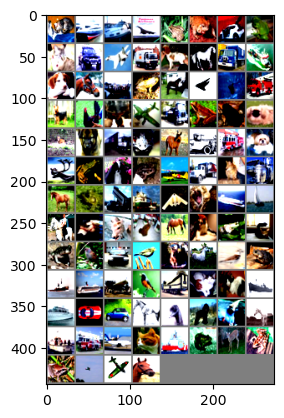

GroundTruth:  cat   ship  ship  plane


In [7]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
net =MOE_LeNET_ResNet(input_size, num_experts, hidden_size, depth, output_size,k=2,loss_coef=1e-2).to(device)
Path= f"/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/_cifar10_moe.pt"
net.load_state_dict(torch.load(Path, weights_only=True))



correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels =data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs,_ = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

/home/zhy/Zhou/mixture_of_experts/_image_run/_model.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict1 =torch.load("/home/zhy/Zhou/mixture_of_experts/_image_r

=== Trainable parameters ===
Total trainable params: 6306

Accuracy of the network on the 10000 test images: 75 %


In [10]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels =data[0].to(device), data[1].to(device)
        outputs,_ = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
    """Accuracy for class: plane is 72.2 %
Accuracy for class: car   is 83.4 %
Accuracy for class: bird  is 57.4 %
Accuracy for class: cat   is 43.0 %
Accuracy for class: deer  is 70.6 %
Accuracy for class: dog   is 76.4 %
Accuracy for class: frog  is 89.2 %
Accuracy for class: horse is 87.5 %
Accuracy for class: ship  is 82.1 %
Accuracy for class: truck is 78.5 %"""

Accuracy for class: plane is 76.9 %
Accuracy for class: car   is 92.5 %
Accuracy for class: bird  is 61.2 %
Accuracy for class: cat   is 58.2 %
Accuracy for class: deer  is 81.0 %
Accuracy for class: dog   is 69.0 %
Accuracy for class: frog  is 86.6 %
Accuracy for class: horse is 82.5 %
Accuracy for class: ship  is 78.9 %
Accuracy for class: truck is 65.2 %
